# Business Problem

Cadio Catch Diseases é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O seu modelo de negócio é do tipo Serviço, ou seja, a empresa ofereço o diagnóstico precoce de uma doença cardiovascular por um certo preço.
Atualmente, o diagnóstico de uma doença cardiovascular é feita manualmente por uma equipe de especialistas.A precisão atual do diagnóstico varia entre 55% e 65%, devido a complexidade do diagnóstico e também da fadiga da equipe que se revezam em turnos para minimizar os riscos. O custo de cada diagnóstico, incluindo os aparelhos e a folha de pagamento dos analistas, gira em torno de R$ 1.000,00.
O preço do diagnóstico, pago pelo cliente, varia de acordo com a precisão conseguida pelo time de especialistas, o cliente paga R$500,00 a cada 5% de acurácia acima de 50%. Por exemplo, para uma precisão de 55%, o diagnóstico custa R$500,00 para o cliente, para uma precisão de 60%, o valor é de R$ 1000,00 e assimpor diante. Se a precisão do diagnóstico for 50% o cliente não paga por ele.

Observe que a variação da precisão dada pelo time de especialistas, faz com que a empresa tenha ora uma operação com lucro, receita maior que o custo, ora uma operação com prejuízo, receita menor que o custo. Essa instabilidade do diagnóstico faz com que a empresa tenha um Cashflow imprevisível.
O seu objetivo como o Cientista de Dados contratado pela Cardio Catch Diseases é criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos.
Portanto o seu trabalho como Data Scientist é criar um ferramenta de classificação de doentes, como umaprecisão estável. Junto com a ferramenta, você precisa enviar um relatório para o CEO da Cardio Catch Diseases, reportando os resultados e respondendo às seguintes perguntas: 

1. Qual a Acurácia e a Precisão da ferramenta?
2. Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
3. Qual a Confiabilidade do resultado dados pela nova ferra enta?

#### Dados

- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men 
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

# Set up

### Libraries

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb

# from sklearn                 import ensemble         as en
from sklearn                 import model_selection  as ms
from matplotlib             import pyplot as plt
from IPython.display        import HTML
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.ensemble        import RandomForestClassifier, BaggingClassifier
from xgboost                 import XGBClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier, BaggingClassifier
from sklearn.metrics         import accuracy_score, recall_score, precision_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



from dython import nominal

### Functions

In [2]:
# # Função para formatar os valores da pressão arterial
def format_pressure(value):
    if value == 1:
        return value * 100.00
    elif 2 <= value <= 20:
        return value * 10.00
    elif 30 <= value <= 240:
        return float(value)
    elif 241 <= value <= 2088:
        return value / 10.00
    else:
        return value / 100.00
    
    
    # Definir intervalor de IMC em categorias
def health(value):
    if value <= 16.9:
        return 0
    elif 17 <= value <= 20:
        return 1
    elif 21 <= value <= 24:
        return 2
    elif 25 <= value <= 29:
        return 3
    elif 30 <= value <= 35:
        return 4
    else:
        return 5
    


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

## ETL

### Import Data

In [4]:
df_train_raw = pd.read_csv('cardio_train.csv', sep=';') 

### Data Raw status

In [5]:
df1 = df_train_raw.copy()

In [6]:
df1.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1


In [7]:
df1.info()

# Types = ok
# Rename Columns (snakecase): ok
# Fillout NaN: ok 
# Rows:70000 
# Cols: 13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### Changing Data

In [8]:
# age - Change to years
df1['age'] = round(df1['age'].apply(lambda x: x / 365.25 ), 2)


# Formatando pressão arterial
df1['ap_lo'] = df1['ap_lo'].map(format_pressure)
df1['ap_hi'] = df1['ap_hi'].map(format_pressure)



In [9]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.36,2,168,62.0,110.0,80.0,1,1,0,0,1,0
1,1,55.38,1,156,85.0,140.0,90.0,3,1,0,0,1,1
2,2,51.63,1,165,64.0,130.0,70.0,3,1,0,0,0,1
3,3,48.25,2,169,82.0,150.0,100.0,1,1,0,0,1,1
4,4,47.84,1,156,56.0,100.0,60.0,1,1,0,0,0,0


# Exploratory Data Analysis

### Univariate Anaysis

In [10]:
df2 = df1.copy()

In [11]:
          
# Número                                        'Categorias'
# AGE: Média, mediana, min, max                 gender: women,  men
# height: Média, mediana, min, max              cholesterol:  normal, above, 3: high
# weight: Média, mediana, min, max              gluc:  normal, above, high
# ap_hi: Média, mediana, min, max               smoke: yes, no
# ap_lo: Média, mediana, min, max               alco: yes, no
#                                               active: yes, no

num_attributes = df2.select_dtypes( include=['int64', 'float64'])


In [12]:
#Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion -std, min, max, range, skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( np.min )).T
d3 = pd.DataFrame( num_attributes.apply( np.max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew()  )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00,99999.00,99999.00,49972.419900,50001.50,28851.096242,-0.001278,-1.198374
1,age,29.56,64.92,35.36,53.302869,53.94,6.754925,-0.307069,-0.823435
2,gender,1.00,2.00,1.00,1.349571,1.00,0.476835,0.630960,-1.601935
3,height,55.00,250.00,195.00,164.359229,165.00,8.210068,-0.642187,7.943653
4,weight,10.00,200.00,190.00,74.205690,72.00,14.395654,1.012070,2.586825
5,ap_hi,-1.50,240.00,241.50,126.979076,120.00,17.169958,0.855635,2.101024
6,ap_lo,-0.70,208.80,209.50,81.659033,80.00,10.235389,0.850847,9.013562
7,cholesterol,1.00,3.00,2.00,1.366871,1.00,0.680245,1.587123,0.993901
8,gluc,1.00,3.00,2.00,1.226457,1.00,0.572266,2.397462,4.294377
9,smoke,0.00,1.00,1.00,0.088129,0.00,0.283482,2.905867,6.444250


#### Graf num

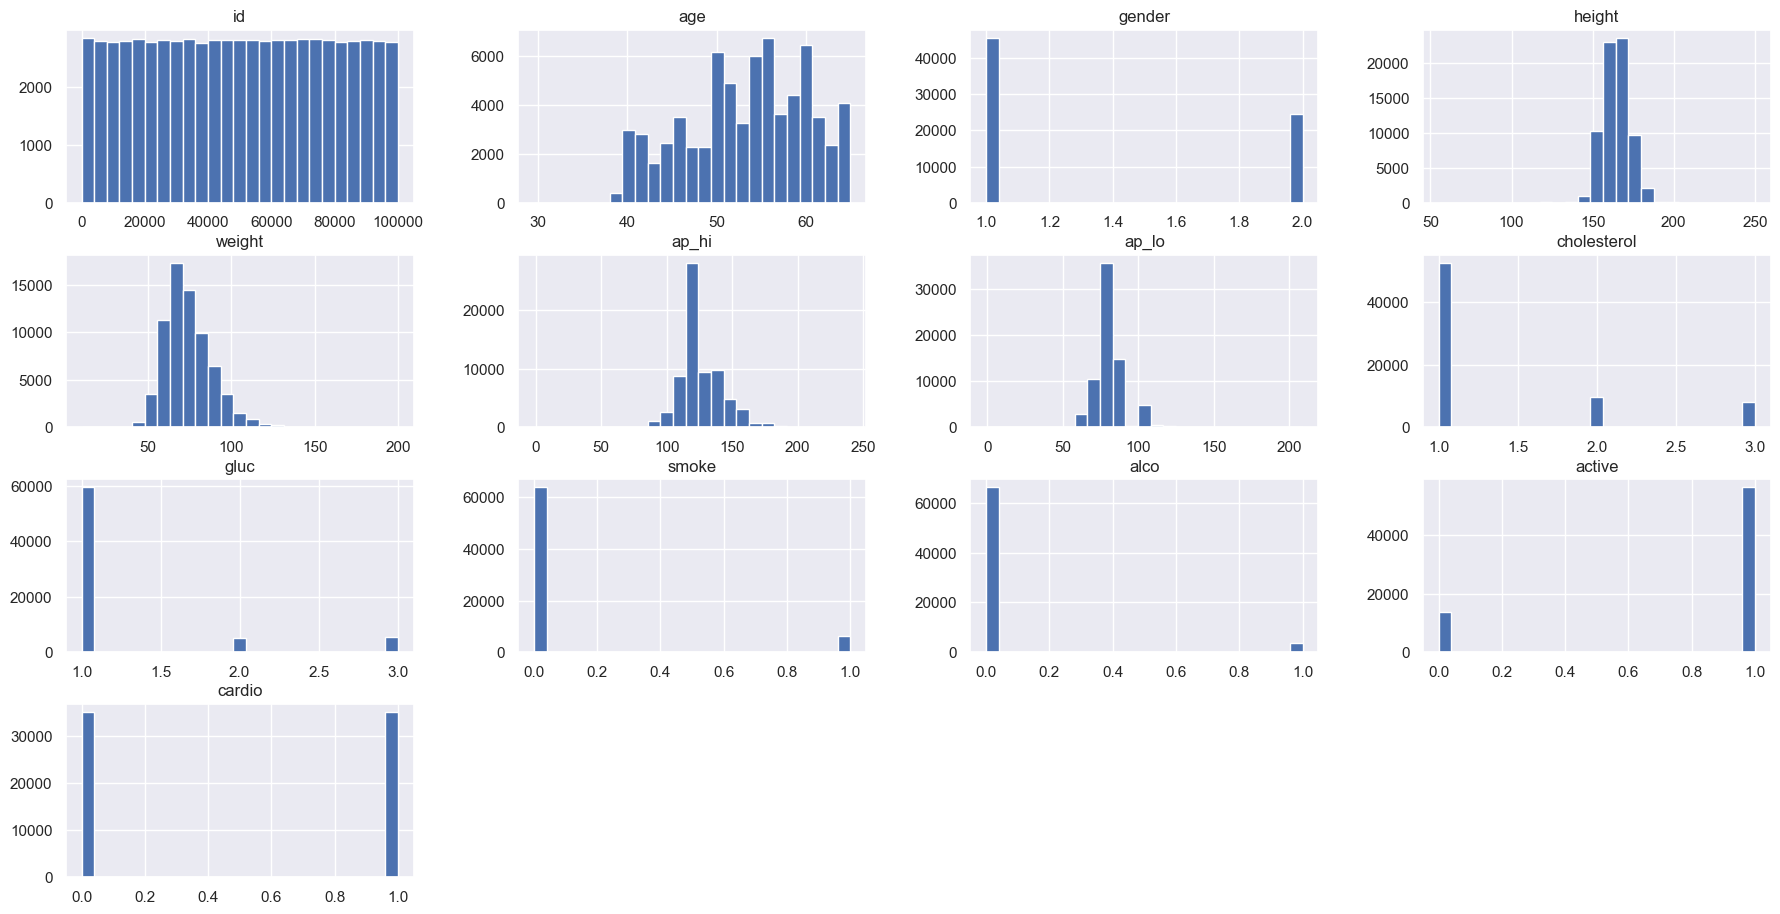

In [13]:
num_attributes.hist( bins=25, figsize=(22,11) );

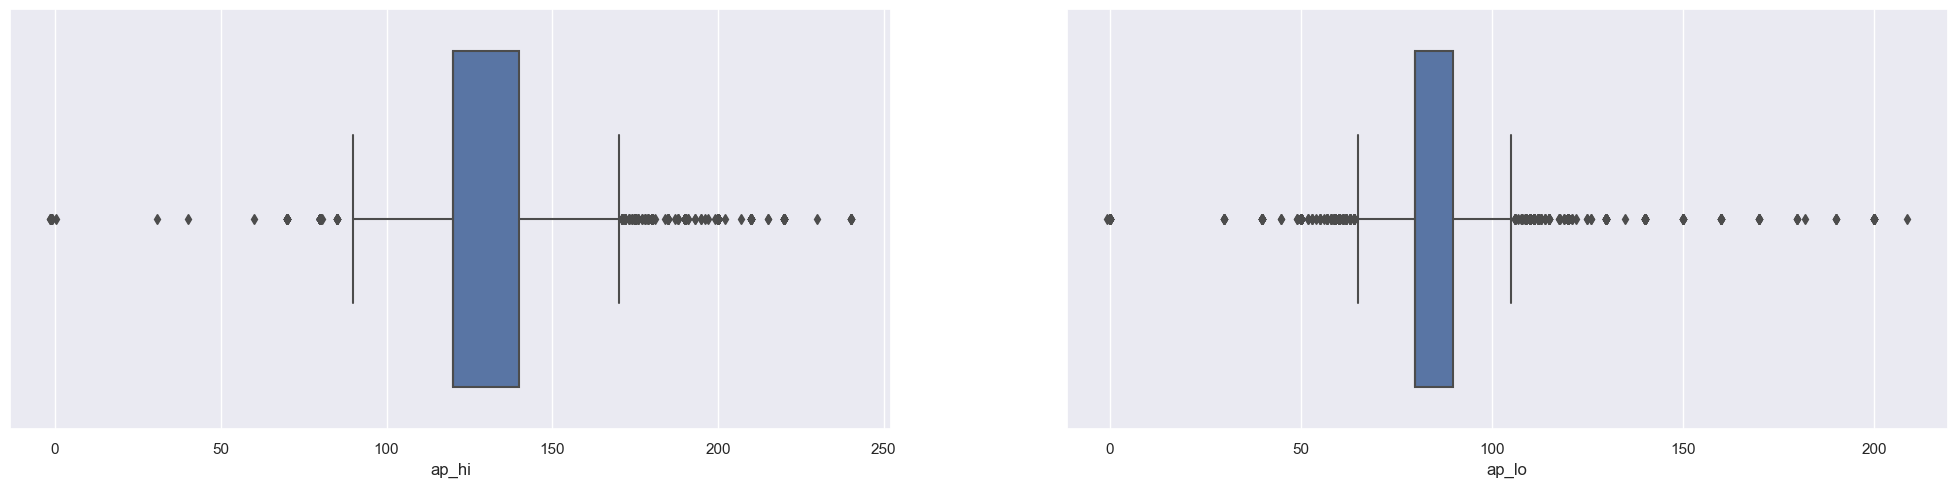

In [14]:
# PA

plt.subplot(2, 2, 1)
sns.boxplot(x='ap_hi',  data=df2);

plt.subplot(2, 2, 2)
sns.boxplot(x='ap_lo',  data=df2);


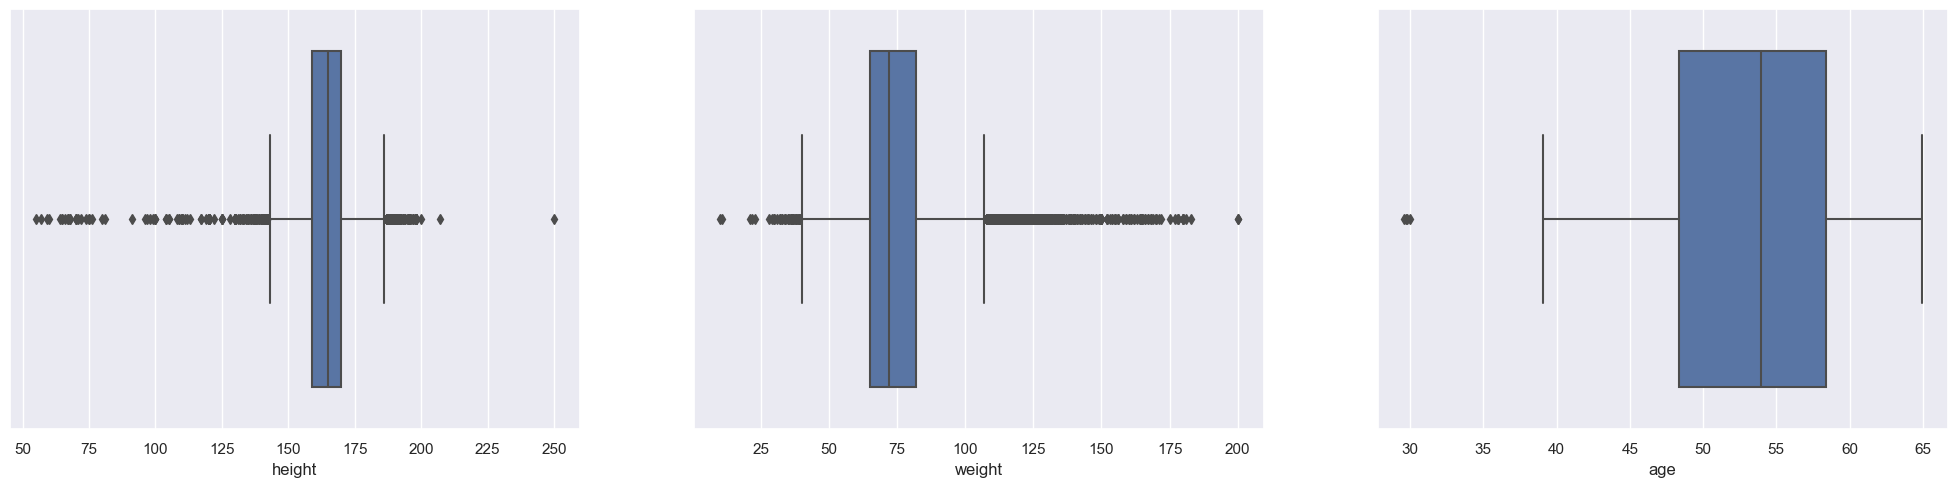

In [15]:
# cm - <130 > 200
plt.subplot(2, 3, 1)
sns.boxplot(x='height',  data=df2);

# KG - <40 > 200
plt.subplot(2, 3, 2)
sns.boxplot(x='weight',  data=df2);

plt.subplot(2, 3, 3)
sns.boxplot(x='age',  data=df2);


In [16]:
# # Avaliando outlier peso/altura

# print(f"Nº menores de 100 cm: {len( df2[df2[ 'height' ] <= 120 ] )} " )
# print(f"Nº maiores de 200 cm: {len(df2[df2['height'] >= 200])} ")
# print(f"Nº mais leves que 40 kg: {len(df2[df2['weight'] <= 40])} ")
# print(f"Nº mais pesados que 170 kg: {len(df2[df2['weight'] >= 170])} ")


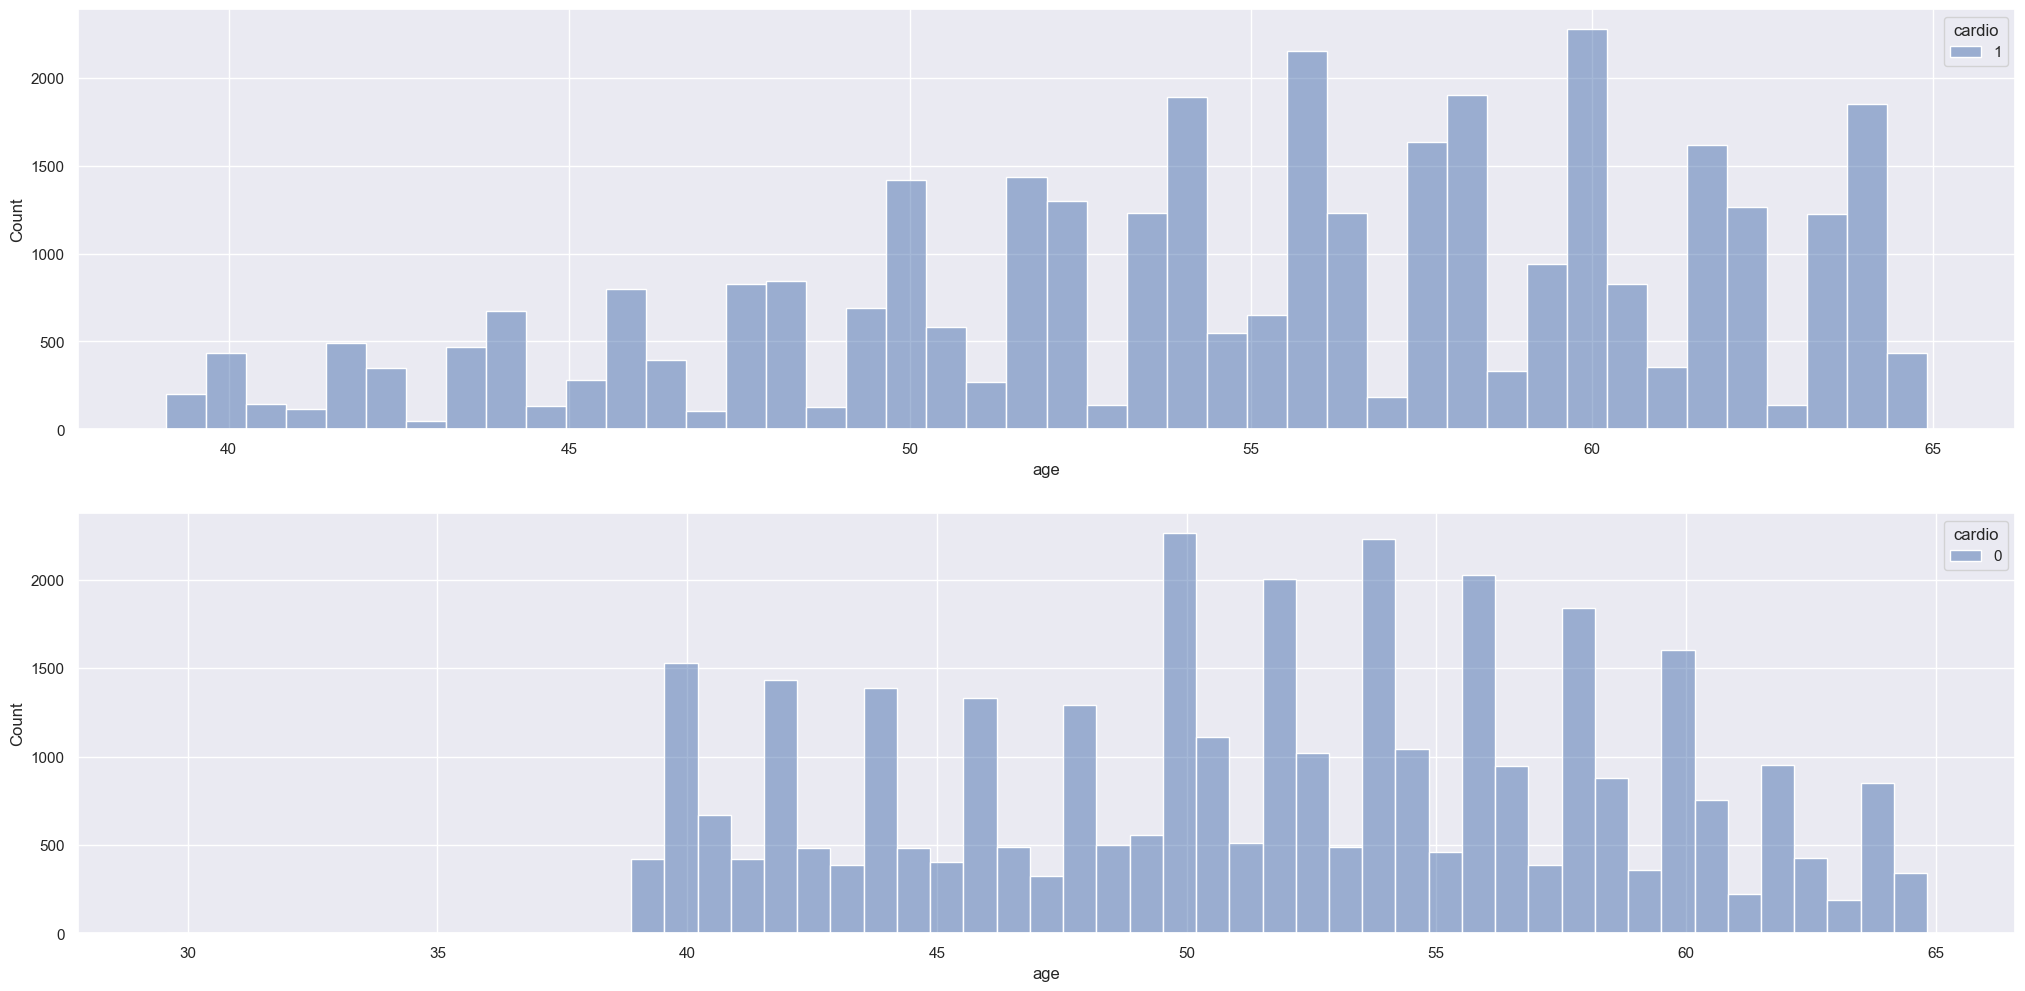

In [17]:

plt.subplot(2,1,1)
sns.histplot(x='age',
             data=df2[(df2['cardio'] == 1)],
             hue='cardio');

plt.subplot(2,1,2)
sns.histplot(x='age',
             data=df2[(df2['cardio'] == 0)],
             hue='cardio');



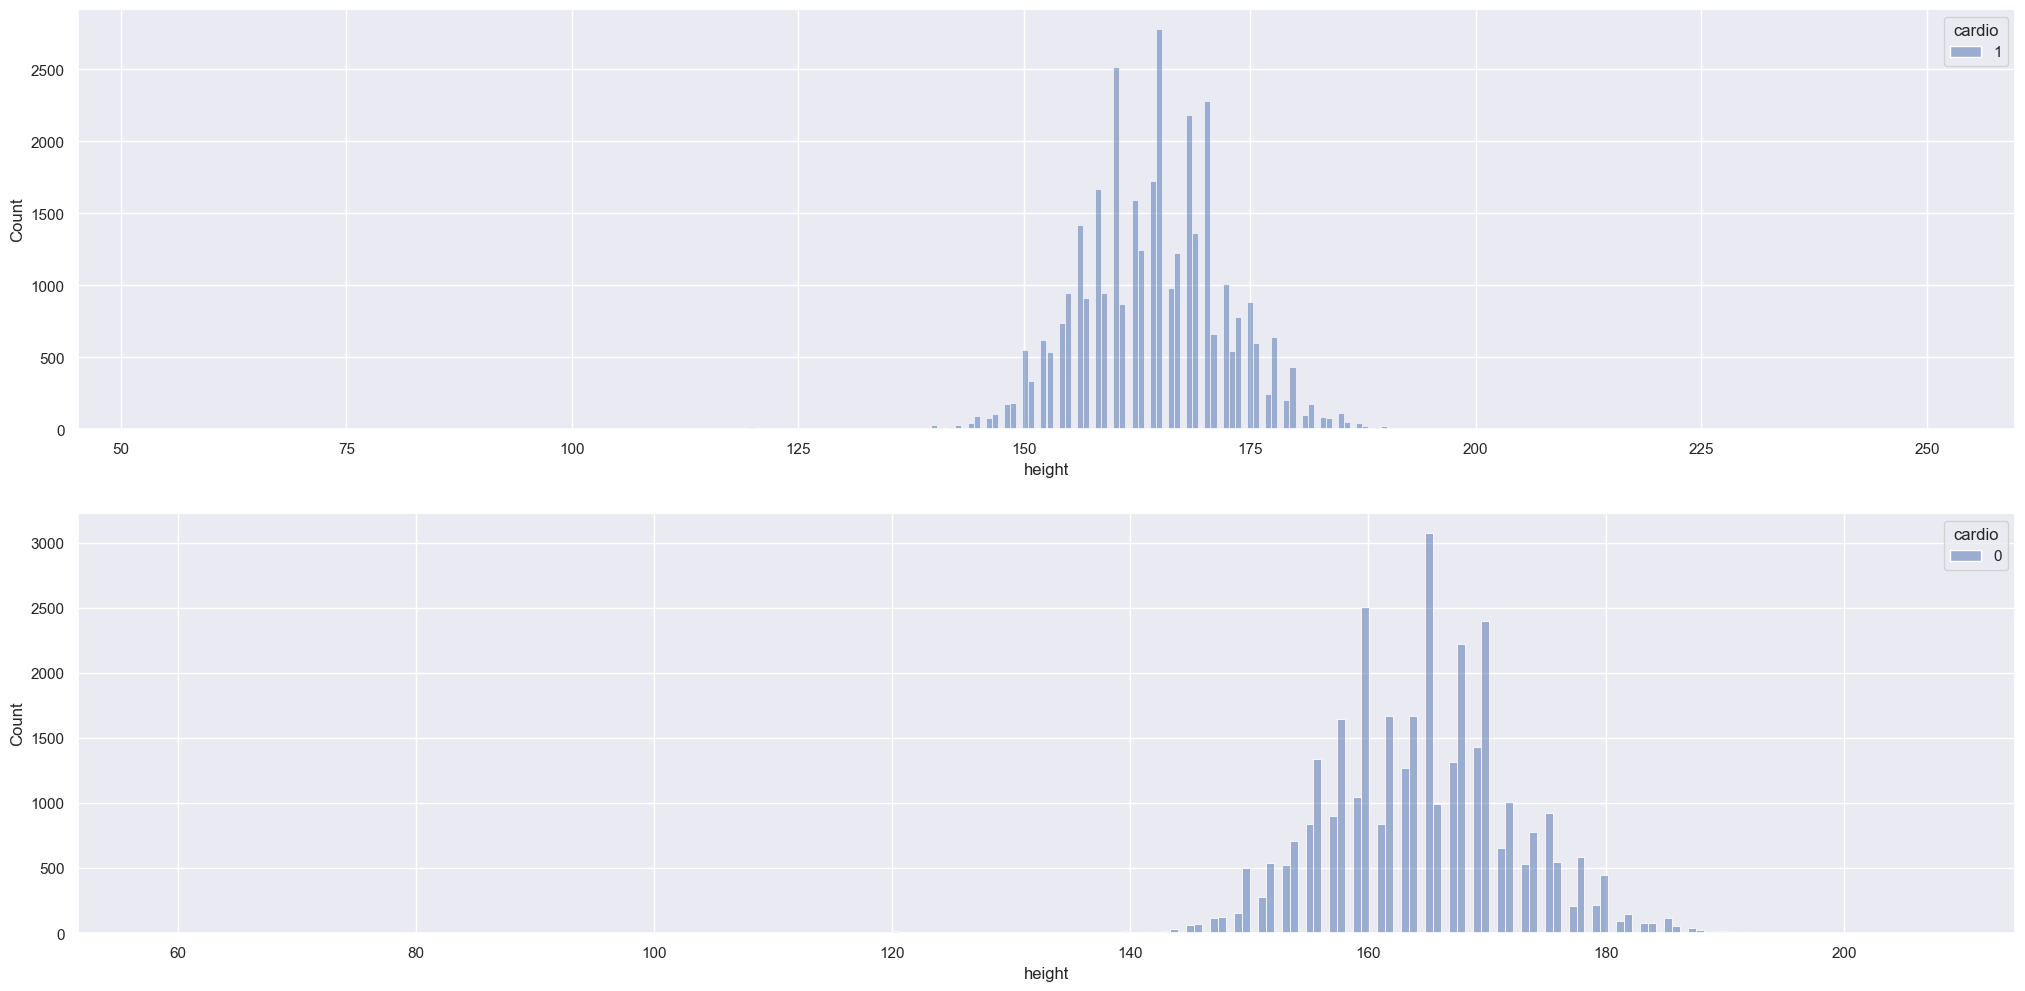

In [18]:
plt.subplot(2,1,1)
sns.histplot(x='height',
             data=df2[(df2['cardio'] == 1)],
             hue='cardio');

plt.subplot(2,1,2)
sns.histplot(x='height',
             data=df2[(df2['cardio'] == 0)],
             hue='cardio');

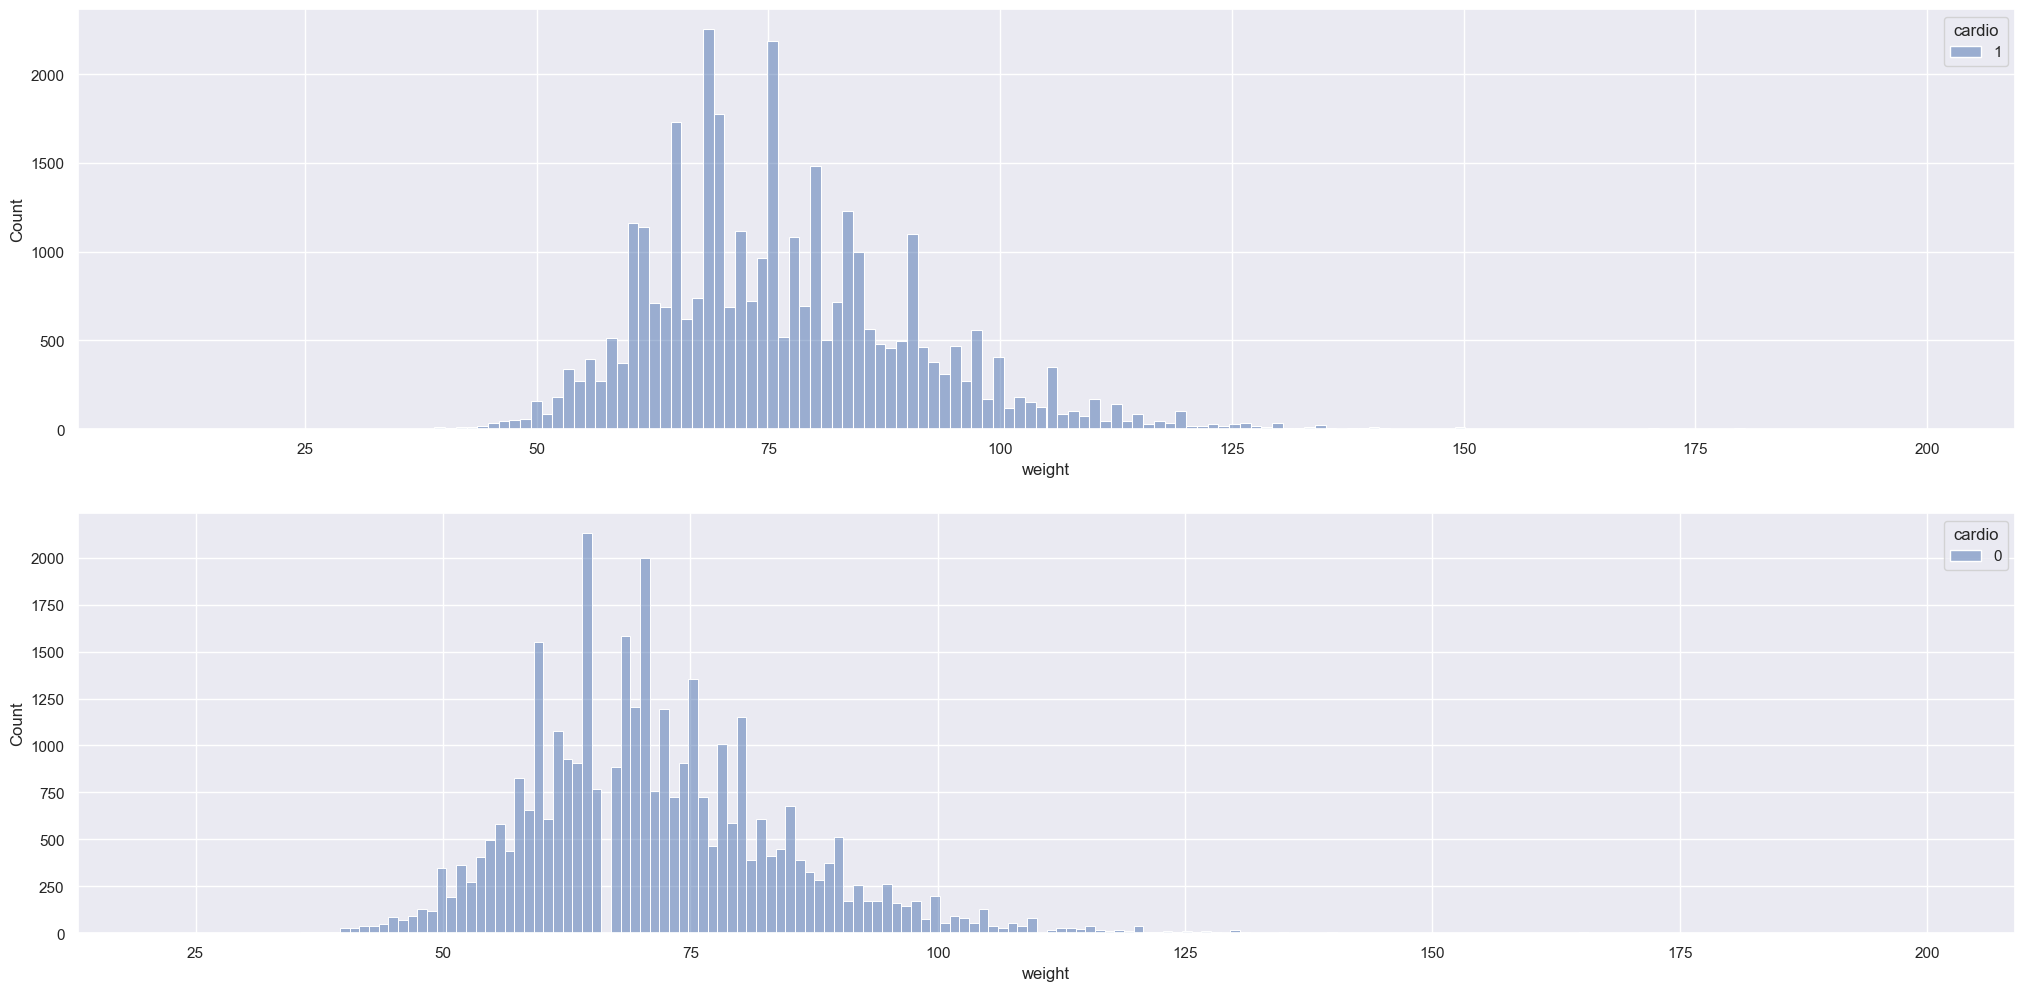

In [19]:
plt.subplot(2,1,1)
sns.histplot(x='weight',
             data=df2[(df2['cardio'] == 1)],
             hue='cardio');

plt.subplot(2,1,2)
sns.histplot(x='weight',
             data=df2[(df2['cardio'] == 0)],
             hue='cardio');




In [20]:
# # Avaliando outlier PA

# print(f"PA low < 30: {len( df2[df2[ 'ap_lo' ] <= 30 ] )} " )
# print(f"PA low < 250: {len( df2[df2[ 'ap_lo' ] >= 240 ] )} " )
# print(f"PA low < 30: {len( df2[df2[ 'ap_hi' ] <= 30 ] )} " )
# print(f"PA low < 250: {len( df2[df2[ 'ap_hi' ] >= 240 ] )} " )


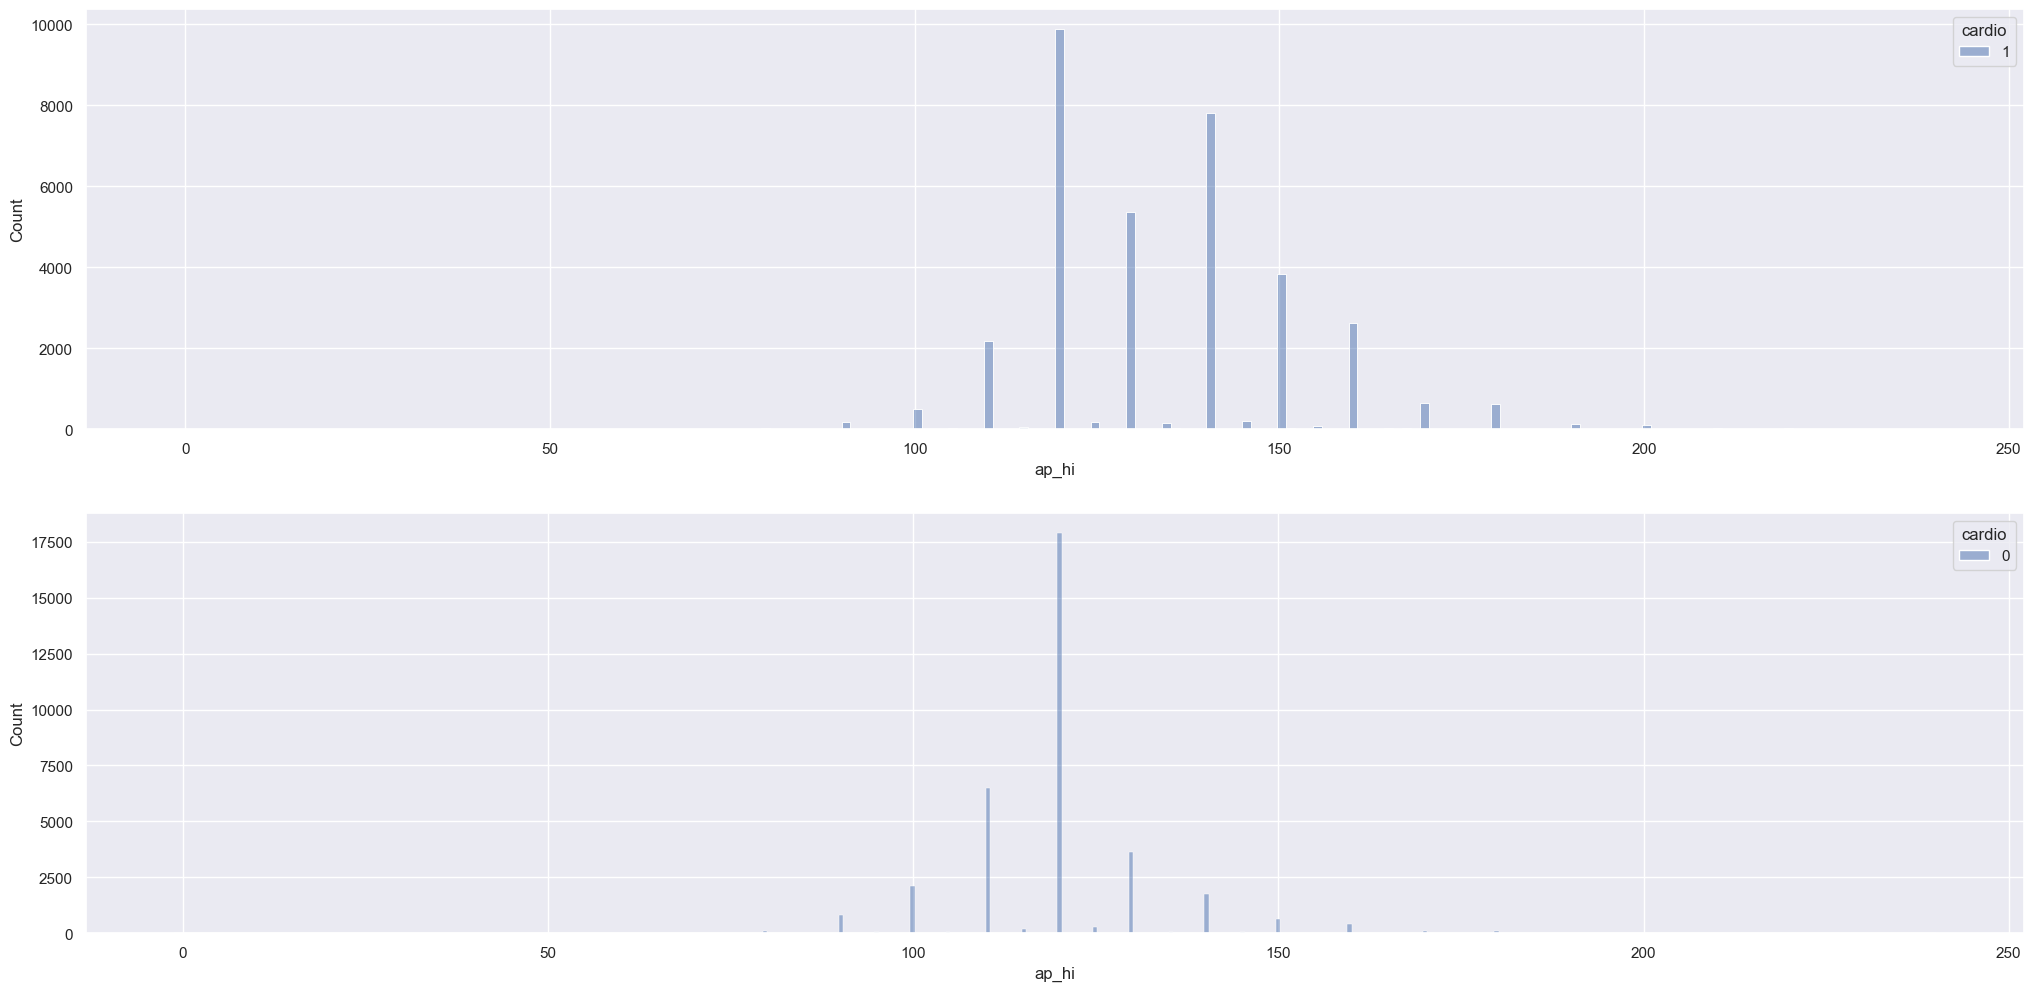

In [21]:
plt.subplot(2,1,1)
sns.histplot(x='ap_hi',
             data=df2[(df2['cardio'] == 1)],
             hue='cardio');

plt.subplot(2,1,2)
sns.histplot(x='ap_hi',
             data=df2[(df2['cardio'] == 0)],
             hue='cardio');


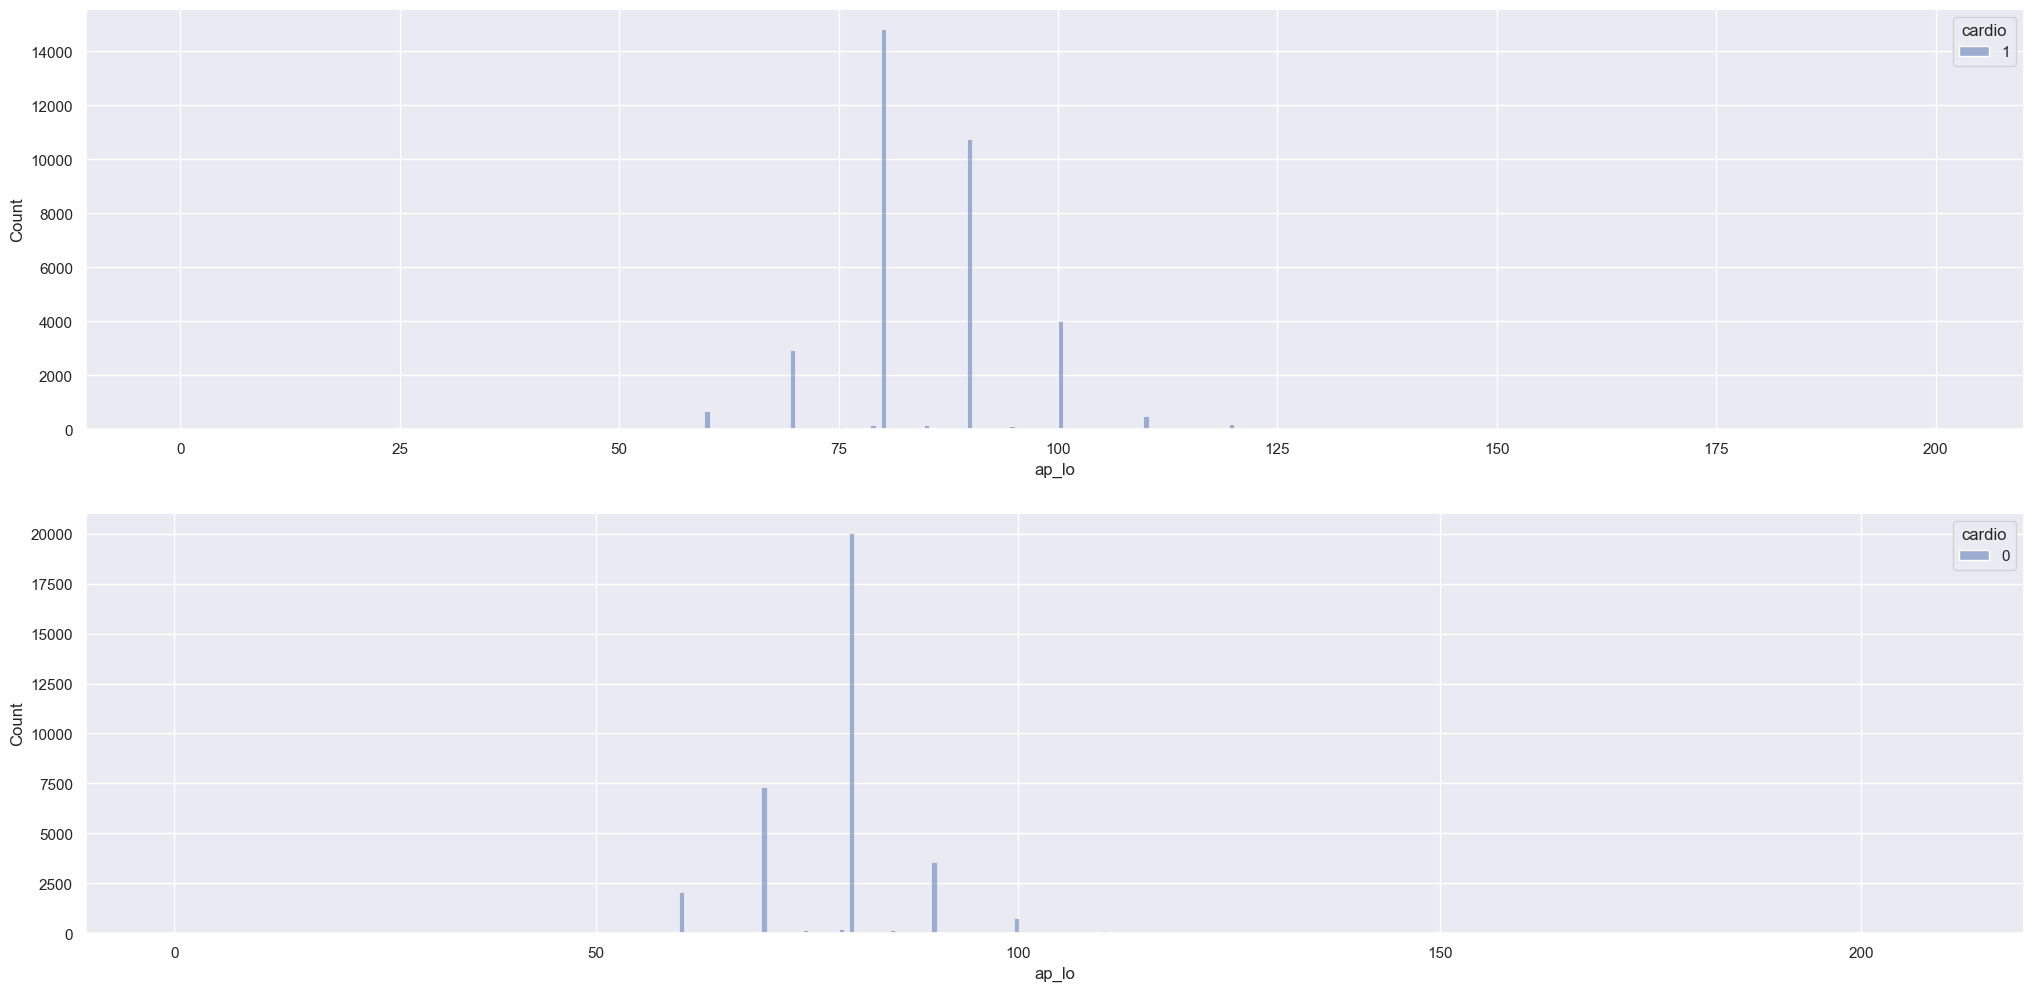

In [22]:

plt.subplot(2,1,1)
sns.histplot(x='ap_lo',
             data=df2[(df2['cardio'] == 1)],
             hue='cardio');

plt.subplot(2,1,2)
sns.histplot(x='ap_lo',
             data=df2[(df2['cardio'] == 0)],
             hue='cardio');

#### Categorical Analysis

In [23]:
# # Desnecessário

# df2['gender'] = df2['gender'].apply(lambda x: 'women' if x == 1 else 'men')
# df2['smoke'] = df2['smoke'].apply(lambda x: 'yes' if x == 1 else 'no')
# df2['alco'] = df2['smoke'].apply(lambda x: 'yes' if x == 1 else 'no')
# df2['active'] = df2['active'].apply(lambda x: 'yes' if x == 1 else 'no')
# # df2['cardio'] = df2['cardio'].apply(lambda x: 'yes' if x == 1 else 'no')
# df2['cholesterol'] = df2['cholesterol'].map({1: 'normal', 2: 'above', 3: 'high'})
# df2['gluc'] = df2['gluc'].map({1: 'normal', 2: 'above', 3: 'high'})

In [24]:
df2.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.36,2,168,62.0,110.0,80.0,1,1,0,0,1,0
1,1,55.38,1,156,85.0,140.0,90.0,3,1,0,0,1,1
2,2,51.63,1,165,64.0,130.0,70.0,3,1,0,0,0,1


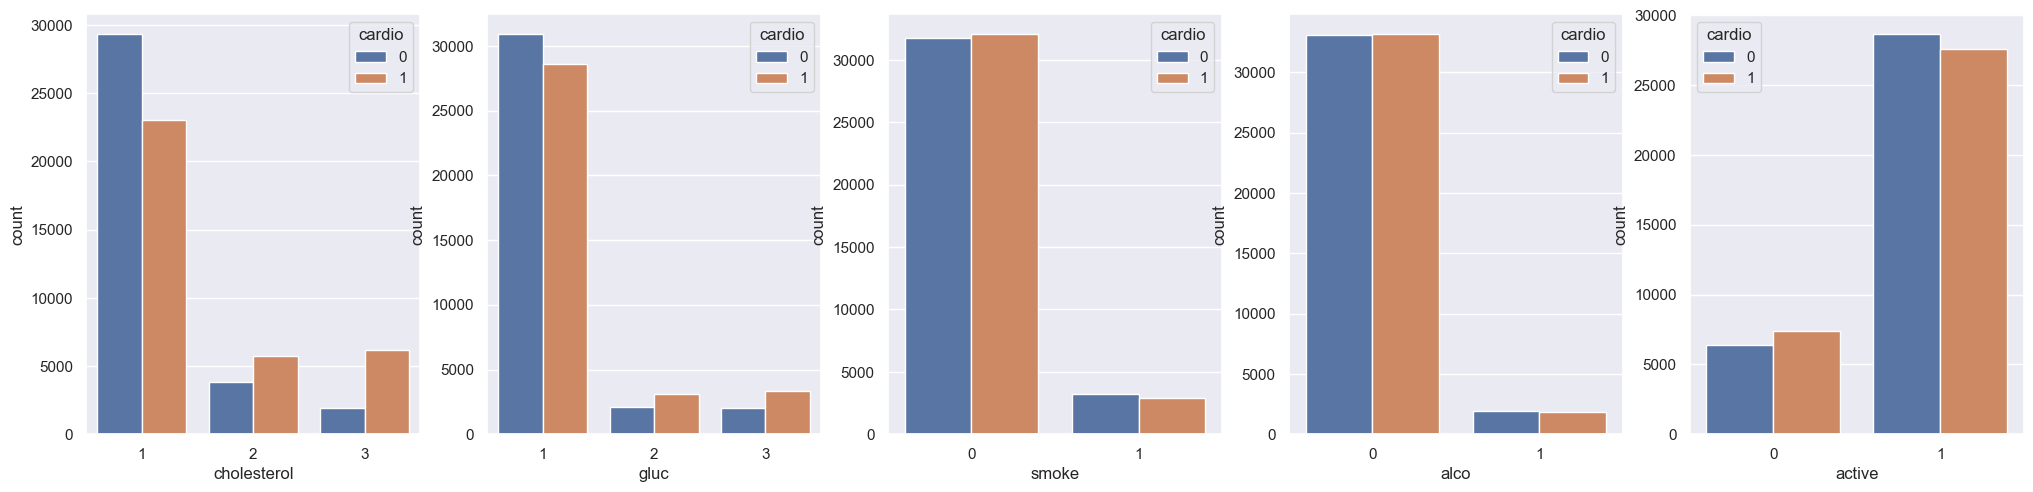

In [25]:
# Categorical analysis

# 'Categorias'
# gender: women,  men
# cholesterol:  normal, above, 3: high
# gluc:  normal, above, high
# smoke: yes, no
# alco: yes, no
# active: yes, no

plt.subplot(2,5,1)
sns.countplot(
    x='cholesterol',
    hue=('cardio'),
    data=df2,
);

plt.subplot(2,5,2)
sns.countplot(
    x='gluc',
    hue=('cardio'),
    data=df2,
);

plt.subplot(2,5,3)
sns.countplot(
     x='smoke',
    hue=('cardio'),
    data=df2,
);

plt.subplot(2,5,4)
sns.countplot(
    x='alco',
    hue=('cardio'),
    data=df2,
);

plt.subplot(2,5,5)
sns.countplot(
     x='active',
    hue=('cardio'),
    data=df2,
);

# df2['gender'] = df2['gender'].apply(lambda x: 'women' if x == 1 else 'men')
# df2['smoke'] = df2['smoke'].apply(lambda x: 'yes' if x == 1 else 'no')
# df2['alco'] = df2['smoke'].apply(lambda x: 'yes' if x == 1 else 'no')
# df2['active'] = df2['active'].apply(lambda x: 'yes' if x == 1 else 'no')
# # df2['cardio'] = df2['cardio'].apply(lambda x: 'yes' if x == 1 else 'no')
# df2['cholesterol'] = df2['cholesterol'].map({1: 'normal', 2: 'above', 3: 'high'})
# df2['gluc'] = df2['gluc'].map({1: 'normal', 2: 'above', 3: 'high'})

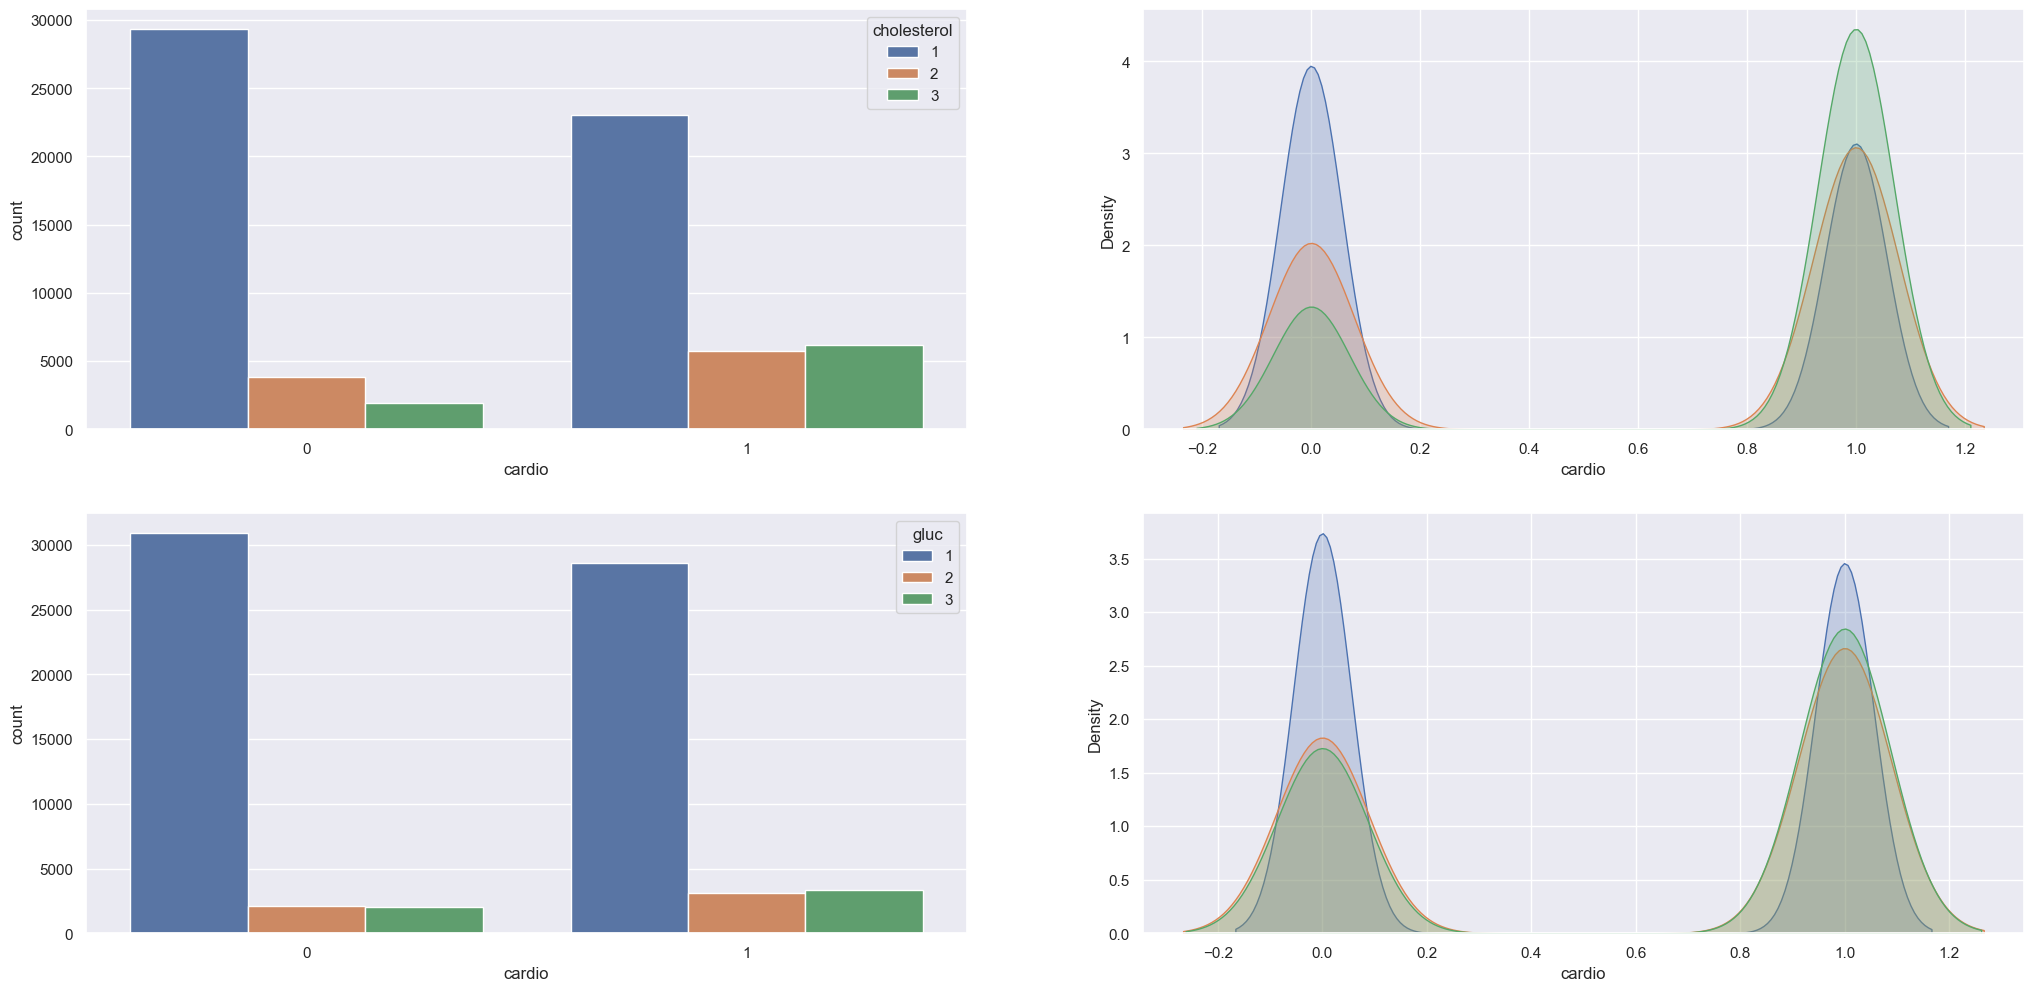

In [26]:
# # cholesterol: 1, 2, 3 | 1: normal, 2: above normal, 3: well above normal
# # gluc: 1, 2, 3 | 1: normal, 2: above normal, 3: well above normal

plt.subplot(2,2,1)
sns.countplot(
    x='cardio',
    hue=('cholesterol'),
    data=df2,
);

plt.subplot( 2, 2, 2 )
sns.kdeplot( df2[df2['cholesterol'] == 1]['cardio'], label=1, fill=True, legend=True  );
sns.kdeplot( df2[df2['cholesterol'] == 2]['cardio'], label=2, fill=True, legend=True );
sns.kdeplot( df2[df2['cholesterol'] == 3]['cardio'], label=3, fill=True, legend=True );

plt.subplot(2,2,3)
sns.countplot(
    x='cardio',
    hue=('gluc'),
    data=df2,
);

plt.subplot( 2, 2, 4 )
sns.kdeplot( df2[df2['gluc'] == 1]['cardio'], label=1, fill=True, legend=True  );
sns.kdeplot( df2[df2['gluc'] == 2]['cardio'], label=2, fill=True, legend=True );
sns.kdeplot( df2[df2['gluc'] == 3]['cardio'], label=3, fill=True, legend=True );



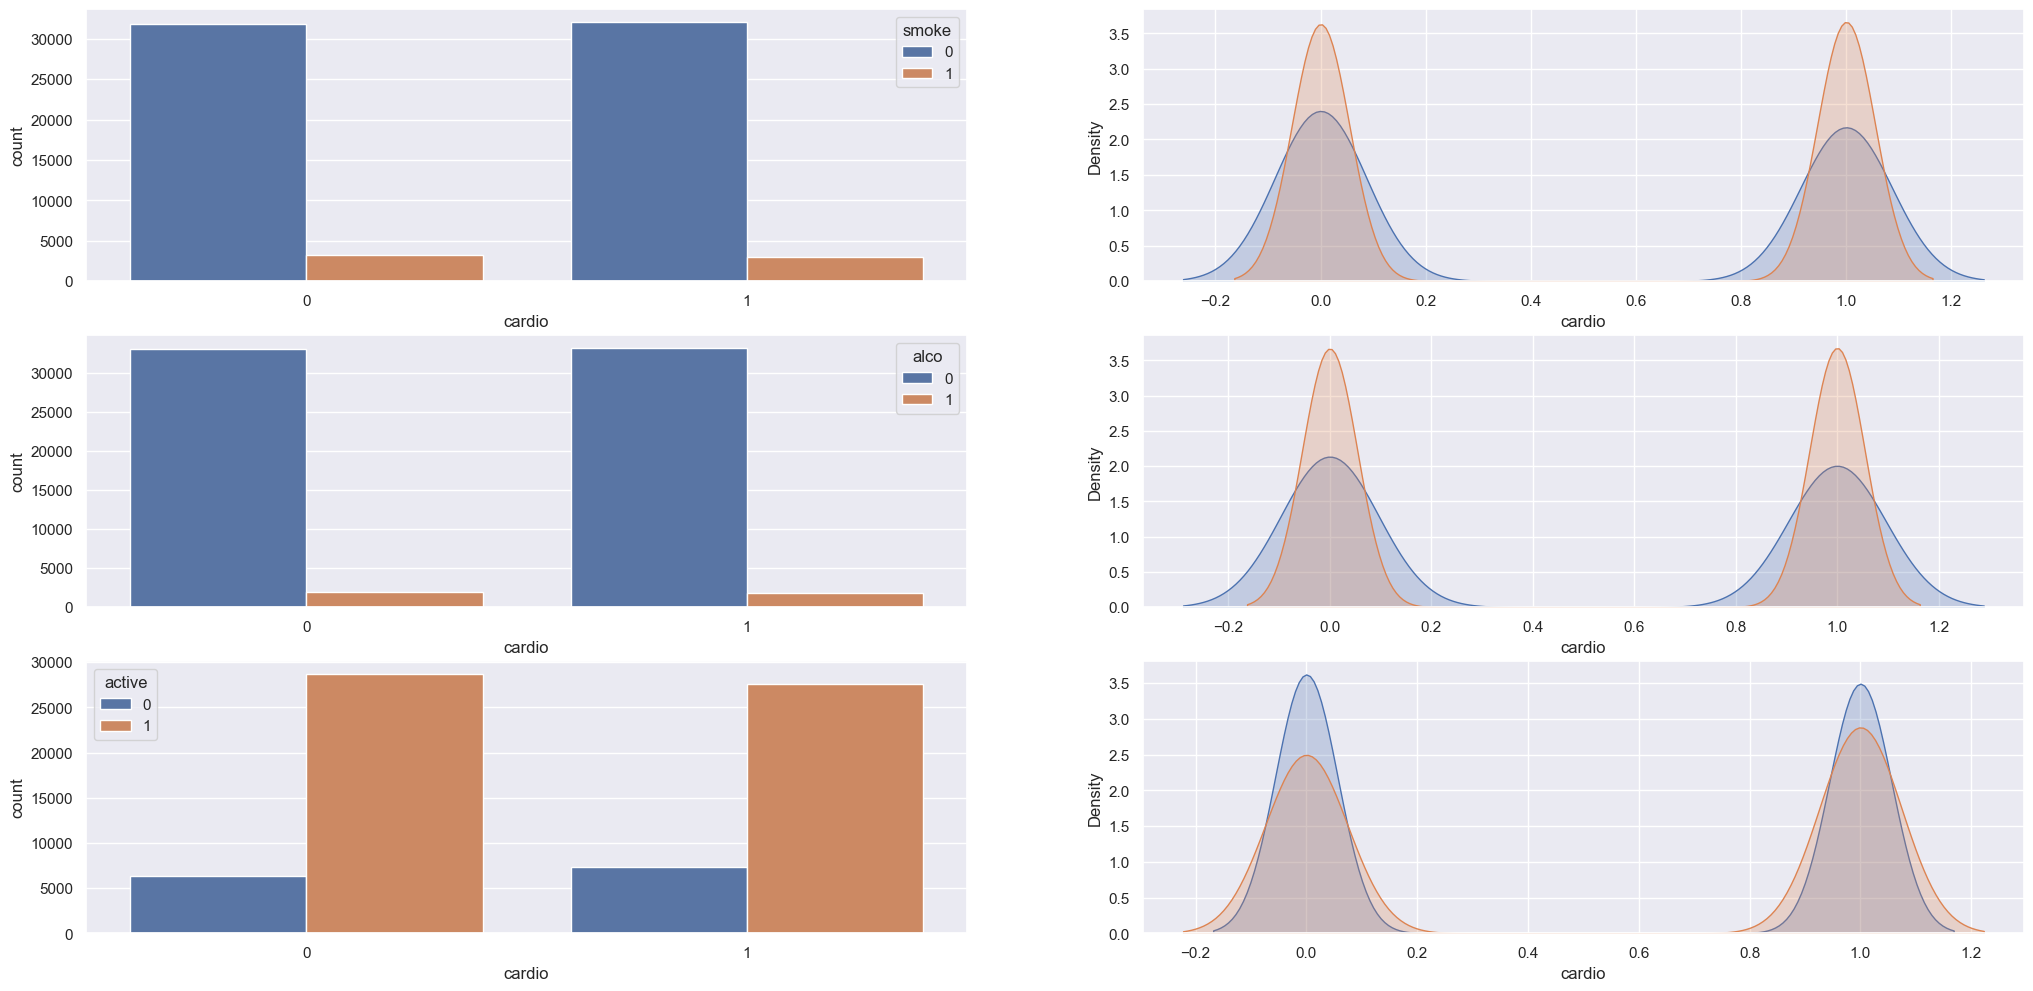

In [27]:
# # smoke: 1, 0 
# # alco: 1, 0
# # active: 1, 0

# Assistir aula do gráfico de densidade!!!!!

plt.subplot(3, 2, 1)
sns.countplot(
    x='cardio',
    hue=('smoke'),
    data=df2,
);

plt.subplot( 3, 2, 2 )
sns.kdeplot( df2[df2['smoke'] == 1]['cardio'], label=1, fill=True, legend=True  );
sns.kdeplot( df2[df2['smoke'] == 0]['cardio'], label=0, fill=True, legend=True );


plt.subplot(3, 2, 3)
sns.countplot(
    x='cardio',
    hue=('alco'),
    data=df2,
);

plt.subplot( 3, 2, 4 )
sns.kdeplot( df2[df2['alco'] == 1]['cardio'], label=1, fill=True, legend=True  );
sns.kdeplot( df2[df2['alco'] == 0]['cardio'], label=0, fill=True, legend=True );


plt.subplot(3, 2, 5)
sns.countplot(
    x='cardio',
    hue=('active'),
    data=df2,
);

plt.subplot( 3, 2, 6 )
sns.kdeplot( df2[df2['active'] == 1]['cardio'], label=1, fill=True, legend=True  ); 
sns.kdeplot( df2[df2['active'] == 0]['cardio'], label=0, fill=True, legend=True );

### Bivariate Analysis

##### Mental Map

#### Hyphoteses List



### Multivariate Analysis

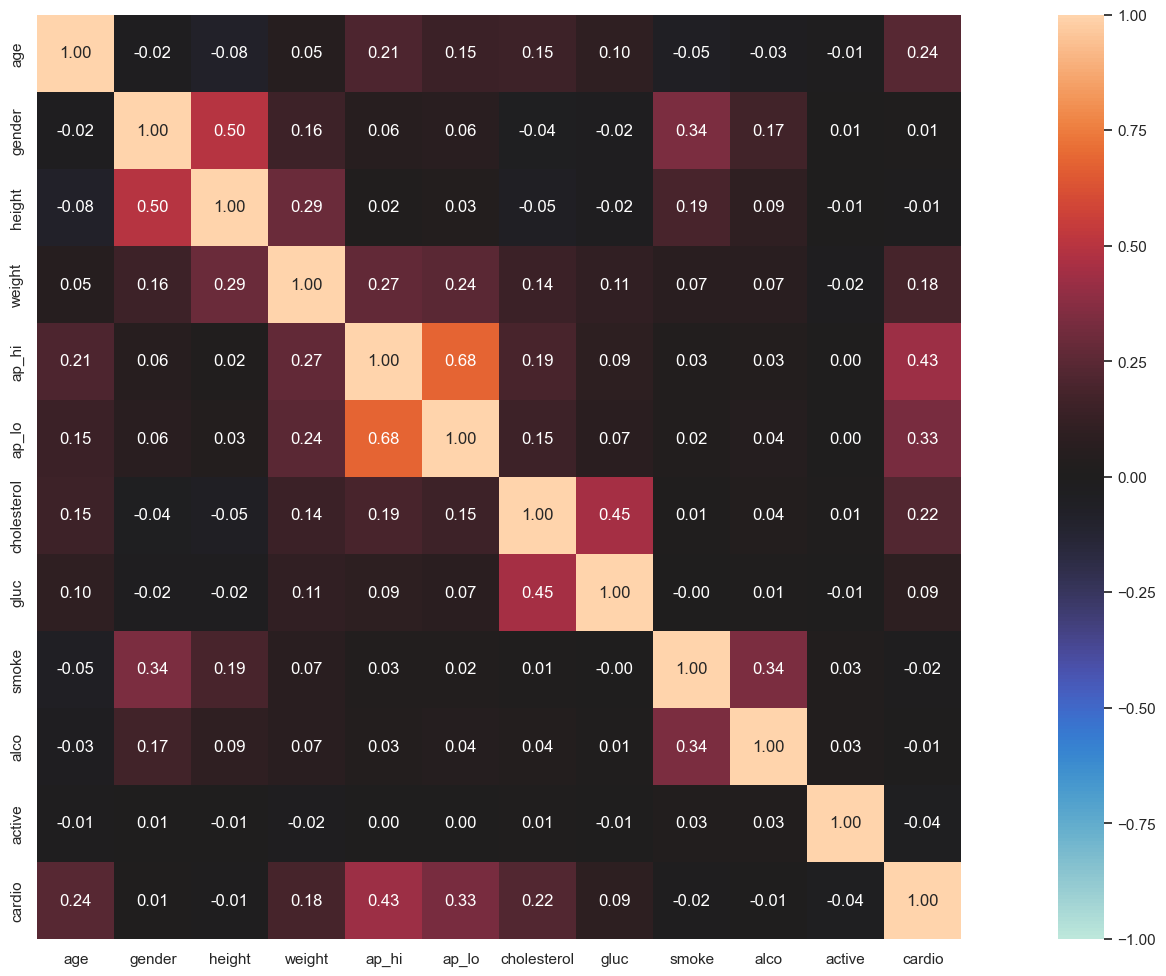

In [28]:
nominal.associations(df2.drop('id',axis = 1));

# Feature Engineering

In [29]:
df3 = df2.copy()

In [30]:
len( df2[df2[ 'ap_lo' ] <= 30 ] )

28

In [31]:
# # Removendo outliers

#Peso/altura
df3 = df3[ (df3['height'] > 120) & (df3['height'] < 200) ]
df3 = df3[ (df3['weight'] > 40) & (df3['weight'] < 170) ]

# Pressão arterial
df3 = df3[ (df3[ 'ap_lo'] > 30 ) & (df3[ 'ap_lo' ] < 150) ] # low min 30 | Max 150
df3 = df3[ (df3[ 'ap_hi' ] > 90 ) & (df3[ 'ap_hi' ] < 200 )] # High min 90 | Max 200


# Creating IMC - weight/height²
df3['imc'] = round(df3['weight'] / (df3['height'] ** 2) * 10000, 2)


## Health_status - Intervalos do IMC 
# magreza - < 16.9
# abaixo - 17 ~ 20
# normal - 20 ~ 24
# acima - 25 ~ 29
# obesidade - 30 ~ 35
# morbides - > 35

df3['health_status'] = df3['imc'].map(health)


# Coluna com intervalos de PA -  'baixa', 'normal', 'elevada', 'estagio I', 'estagio II', 'crise hipertensiva'


In [32]:
df3.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imc,health_status
0,0,50.36,2,168,62.0,110.0,80.0,1,1,0,0,1,0,21.97,2
1,1,55.38,1,156,85.0,140.0,90.0,3,1,0,0,1,1,34.93,4
2,2,51.63,1,165,64.0,130.0,70.0,3,1,0,0,0,1,23.51,2
3,3,48.25,2,169,82.0,150.0,100.0,1,1,0,0,1,1,28.71,3
4,4,47.84,1,156,56.0,100.0,60.0,1,1,0,0,0,0,23.01,2
5,8,60.00,1,151,67.0,120.0,80.0,2,2,0,0,0,0,29.38,5
6,9,60.54,1,157,93.0,130.0,80.0,3,1,0,0,1,0,37.73,5
7,12,61.83,2,178,95.0,130.0,90.0,3,3,0,0,1,1,29.98,5
8,13,48.37,1,158,71.0,110.0,70.0,1,1,0,0,1,0,28.44,3
9,14,54.30,1,164,68.0,110.0,60.0,1,1,0,0,0,0,25.28,3


# Data Preparation

In [56]:
df4 = df3.copy()

### Split data

In [57]:
X = df4.drop(['id','cardio'], axis=1)
y = df4['cardio']

In [58]:
# Dataset (100%) -> Treino(80%) e Teste(20%)

X_train, x_test, Y_train, y_test = ms.train_test_split(X, y, test_size=0.20)

In [59]:
# Treino(80%) -> treino(60%) e validação(20%)

x_train, x_validation, y_train, y_validation = ms.train_test_split(X_train, Y_train, test_size=0.20)
df_train = pd.concat([x_train, y_train], axis=1) # juntar as variaveis preditoras com a variavel alvo
df_val = pd.concat([x_validation, y_validation], axis=1) # juntar as variaveis preditoras com a variavel alvo
df_teste = pd.concat([x_test, y_test], axis=1) # juntar as variaveis preditoras com a variavel alvo


### Preparation

In [60]:
# sns.boxplot(x='imc',  data=df4);

In [61]:
# Rescaling dados treino - .fit_transform

rs = RobustScaler()
mms = MinMaxScaler()

# RobustScaler
df_train['ap_hi'] = rs.fit_transform( df_train[ [ 'ap_hi' ] ].values )
df_train['ap_lo'] = rs.fit_transform(df_train[['ap_lo']].values)
df_train['weight'] = rs.fit_transform(df_train[['weight']].values)
df_train['height'] = rs.fit_transform(df_train[['height']].values)
df_train['age'] = rs.fit_transform(df_train[['age']].values)
df_train['imc'] = rs.fit_transform(df_train[['imc']].values)

# MMS
df_train['health_status'] = mms.fit_transform(df_train[['health_status']].values)




In [62]:
# Rescaling dados teste - .transform


df_teste['ap_hi'] = rs.transform(df_teste[['ap_hi']].values)
df_teste['ap_lo'] = rs.transform(df_teste[['ap_lo']].values)
df_teste['weight'] = rs.transform(df_teste[['weight']].values)
df_teste['height'] = rs.transform(df_teste[['height']].values)
df_teste['age'] = rs.transform(df_teste[['age']].values)
df_teste['imc'] = rs.transform(df_teste[['imc']].values)

# MMS
df_teste['health_status'] = mms.transform(df_teste[['health_status']].values)


In [63]:
# Rescaling dados validação - .transform


df_val['ap_hi'] = rs.transform(df_val[['ap_hi']].values)
df_val['ap_lo'] = rs.transform(df_val[['ap_lo']].values)
df_val['weight'] = rs.transform(df_val[['weight']].values)
df_val['height'] = rs.transform(df_val[['height']].values)
df_val['age'] = rs.transform(df_val[['age']].values)
df_val['imc'] = rs.transform(df_val[['imc']].values)


df_val['health_status'] = mms.transform(df_val[['health_status']].values)


In [64]:
# Rescaling dados validação - .transform


X['ap_hi'] = rs.transform(X[['ap_hi']].values)
X['ap_lo'] = rs.transform(X[['ap_lo']].values)
X['weight'] = rs.transform(X[['weight']].values)
X['height'] = rs.transform(X[['height']].values)
X['age'] = rs.transform(X[['age']].values)
X['imc'] = rs.transform(X[['imc']].values)


X['health_status'] = mms.transform(X[['health_status']].values)

In [65]:
df_train.head(2)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,imc,health_status,cardio
43926,0.976861,1,0.363636,1.411765,0.0,0.0,3,3,0,0,1,1.122066,0.8,1
14683,0.230382,2,1.181818,0.882353,0.0,0.0,1,1,0,0,0,0.159624,0.6,1


## Feature Selection

In [66]:
# Crie e treine o modelo LGBMClassifier
lgb_model = lgb.LGBMClassifier(n_jobs=-1, random_state=42)
lgb_model.fit(x_train, y_train)

# Obtenha as importâncias das características do modelo
importances = lgb_model.feature_importances_

# Ordene as características por importância decrescente
indices = np.argsort(importances)[::-1]

# Imprima o ranking das características
print('Feature ranking')
df = pd.DataFrame()

for i, j in zip(x_train.columns, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# São as mesmas que já selecionei

[LightGBM] [Info] Number of positive: 22074, number of negative: 21738
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503835 -> initscore=0.015339
[LightGBM] [Info] Start training from score 0.015339
Feature ranking
         feature  importance
0            age         742
0            imc         556
0         weight         401
0         height         340
0          ap_hi         278
0          ap_lo         188
0    cholesterol         141
0           gluc         109
0         active          74
0         gender          60
0          smoke          44
0  health_status          39
0           alco          28


# Machine Learning

In [91]:
cols_selected = ['age', 'imc', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'gender', 'active', 'smoke', 'gender', 'alco', 'health_status' ]

#Treino
x_train = df_train[cols_selected]

# Validação
x_val = df_val[cols_selected]
y_val = df_val['cardio']

#Teste
x_teste = df_teste[cols_selected]
y_teste = df_teste['cardio']

# Final
x_final = X[cols_selected]


### Cros-Validation

In [93]:
# Validação cruzada Leave One Out
kf = StratifiedKFold(n_splits = 10)

In [94]:
# Verificando a performance da Regressão Logística

lista_de_medidas = ['precision']

modelo = LogisticRegression() # Var Resposta binária
accs_vc = cross_validate(modelo, x_train, y_train, cv = kf, scoring = lista_de_medidas)

In [95]:
print(accs_vc['test_precision'].mean())

0.7528116358118495


### Machine Learning

In [96]:
def MachineLearning(dataset):

    lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']

    nome_das_medidas = ['acurácia', 'recall', 'precision', 'eficiência', 'f1-score']

    lista_de_modelos = [LogisticRegression(),
                        DecisionTreeClassifier(max_depth = 3),
                        DecisionTreeClassifier(max_depth = 5),
                        DecisionTreeClassifier(max_depth = 7),
                        KNeighborsClassifier(n_neighbors = 5),
                        KNeighborsClassifier(n_neighbors = 15),
                        KNeighborsClassifier(n_neighbors = 25),
                        BaggingClassifier(),
                        RandomForestClassifier(n_estimators=300, max_depth = 3, max_features = 3),
                        RandomForestClassifier(n_estimators=300, max_depth = 3, max_features = 4),
                        RandomForestClassifier(n_estimators=300, max_depth = 6, max_features = 3),
                        RandomForestClassifier(n_estimators=300, max_depth = 6, max_features = 4)]

    nome_dos_modelos = ['Regressão Logística',
                        'Árvore (prof = 3)',
                        'Árvore (prof = 5)',
                        'Árvore (prof = 7)',
                        '5-NN',
                        '15-NN',
                        '25-NN',
                        'Bagging',
                        'Random Forest (prof = 3, mf = 3)',
                        'Random Forest (prof = 3, mf = 4)',
                        'Random Forest (prof = 6, mf = 3)',
                        'Random Forest (prof = 6, mf = 4)']

    resultados0 = {}

    for i in range(len(lista_de_modelos)):
        print('Rodando modelo: ' + nome_dos_modelos[i])
        accs_vc = cross_validate(lista_de_modelos[i], x_train, y_train, cv = kf, scoring = lista_de_medidas)


        acc = accs_vc['test_accuracy'].mean()
        sen = accs_vc['test_recall'].mean()
        vpp = accs_vc['test_precision'].mean()
        bac = accs_vc['test_balanced_accuracy'].mean()
        f1s = accs_vc['test_f1'].mean()

        resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, f1s, bac]
    
    resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

    return resultados

In [97]:
# MachineLearning(df_train)

In [98]:
# modelo RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_depth = 6, max_features = 4)


rf.fit(x_final, y)
y_pred = rf.predict( x_teste )

# Calculando as métricas de avaliação com base nas previsões da validação cruzada
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.7362693543675138
Recall: 0.6770150123888646
Precision: 0.7690397350993378
Balanced Accuracy: 0.7363994693037867
F1 Score: 0.7200992171149524


## Fine Tuning

In [99]:
# param_grid = {
#     'n_estimators': [1000,1500, 1700, 2500],
#     'max_features': ['sqrt', 'log2', None],
#     'max_depth': [3, 6, 9],
#     'max_leaf_nodes': [3, 6, 9],
# }

In [101]:
# grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid )
# grid_search.fit(x_val, y_val)

# print(grid_search.best_estimator_)


# RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=9,n_estimators=1000)

RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=9,
                       n_estimators=1000)


## Final Result

In [104]:
# modelo BaggingClassifier
final_model = RandomForestClassifier(max_depth=6, max_features=4, max_leaf_nodes=9, n_estimators=300)


final_model.fit(x_final, y)
y_pred = final_model.predict( x_teste )

# Calculando as métricas de avaliação com base nas previsões da validação cruzada
accuracy = accuracy_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
precision = precision_score(y_teste, y_pred)
balanced_accuracy = balanced_accuracy_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.7294770669003798
Recall: 0.6853228392362629
Precision: 0.7526812870177685
Balanced Accuracy: 0.7295740239220401
F1 Score: 0.7174244736039058
